### Controller Demo

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [6]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Load chromatogram data exported from R

In [7]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
chromatograms = ChromatogramCreator(xcms_output)

DEBUG:Chemicals:Loading 0 chromatograms
../codes\VMSfunctions\Common.py:56: RuntimeWarning:

divide by zero encountered in double_scalars

DEBUG:Chemicals:Loading 5000 chromatograms
DEBUG:Chemicals:Loading 10000 chromatograms
DEBUG:Chemicals:Loading 15000 chromatograms
DEBUG:Chemicals:Loading 20000 chromatograms
DEBUG:Chemicals:Loading 25000 chromatograms
DEBUG:Chemicals:Loading 30000 chromatograms
DEBUG:Chemicals:Loading 35000 chromatograms
DEBUG:Chemicals:Loading 40000 chromatograms
DEBUG:Chemicals:Loading 45000 chromatograms


### Generate some chemicals

In [8]:
hmdb = load_obj('../models/hmdb_compounds.p')

In [9]:
chemicals = ChemicalCreator(ps, chromatograms)

In [11]:
min_ms1_intensity = 2E5
rt_range = [(3*60, 21*60)]
mz_range = [(0, 1000)]
dataset = chemicals.sample(mz_range, rt_range, min_ms1_intensity, 2000, 2, "Known", None, hmdb, 0.1)

DEBUG:Chemicals:2000 ms1 peaks to be created.
DEBUG:Chemicals:i = 0
DEBUG:Chemicals:i = 25
DEBUG:Chemicals:i = 50
DEBUG:Chemicals:i = 75
DEBUG:Chemicals:i = 100
DEBUG:Chemicals:i = 125
DEBUG:Chemicals:i = 150
DEBUG:Chemicals:i = 175
DEBUG:Chemicals:i = 200
DEBUG:Chemicals:i = 225
DEBUG:Chemicals:i = 250
DEBUG:Chemicals:i = 275
DEBUG:Chemicals:i = 300
DEBUG:Chemicals:i = 325
DEBUG:Chemicals:i = 350
DEBUG:Chemicals:i = 375
DEBUG:Chemicals:i = 400
DEBUG:Chemicals:i = 425
DEBUG:Chemicals:i = 450
DEBUG:Chemicals:i = 475
DEBUG:Chemicals:i = 500
DEBUG:Chemicals:i = 525
DEBUG:Chemicals:i = 550
DEBUG:Chemicals:i = 575
DEBUG:Chemicals:i = 600
DEBUG:Chemicals:i = 625
DEBUG:Chemicals:i = 650
DEBUG:Chemicals:i = 675
DEBUG:Chemicals:i = 700
DEBUG:Chemicals:i = 725
DEBUG:Chemicals:i = 750
DEBUG:Chemicals:i = 775
DEBUG:Chemicals:i = 800
DEBUG:Chemicals:i = 825
DEBUG:Chemicals:i = 850
DEBUG:Chemicals:i = 875
DEBUG:Chemicals:i = 900
DEBUG:Chemicals:i = 925
DEBUG:Chemicals:i = 950
DEBUG:Chemicals:i = 975

KnownChemical - 'C15H8O7' rt=427.75 max_intensity=489118.81
[104077.9453125  74673.1640625 129896.0546875 489115.15625
 318675.4375    182189.46875    77059.78125    56049.3828125]


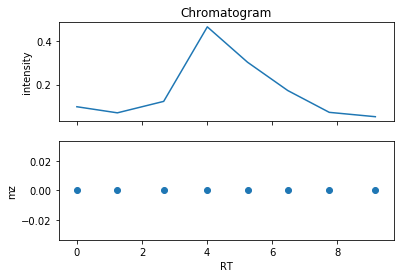

KnownChemical - 'C14H14ClNOS' rt=658.80 max_intensity=917534.41
[418681.09375  408360.34375  440582.875    526089.0625   853473.6875
 917676.75     786943.1875   679439.5      595627.75     433017.625
 352141.0625   152035.484375]


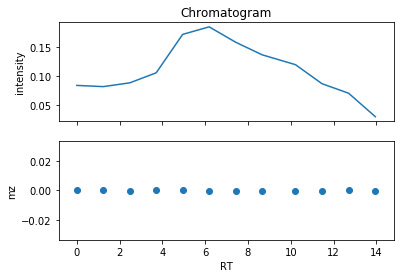

KnownChemical - 'C18H36O2' rt=294.59 max_intensity=820844.04
[559765.3125 612798.75   781689.125  820419.125  810491.5    820756.125
 754543.125  767530.5625 677292.75  ]


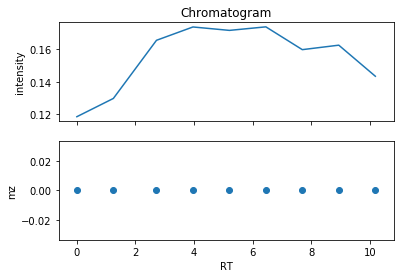

KnownChemical - 'C8H6ClNO3' rt=292.46 max_intensity=280094.60
[ 75047.0390625 202059.265625  240331.09375   268087.375
 280088.34375   235507.59375    81083.7734375]


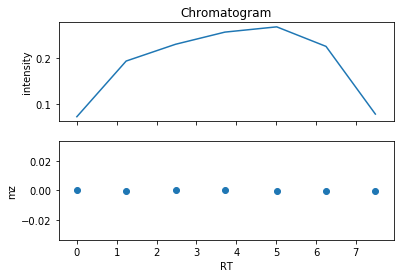

KnownChemical - 'C18H32O' rt=780.52 max_intensity=350355.63
[148701.609375 193569.015625 206798.84375  260590.75     264464.
 286973.125    275456.28125  350355.8125   300917.0625  ]


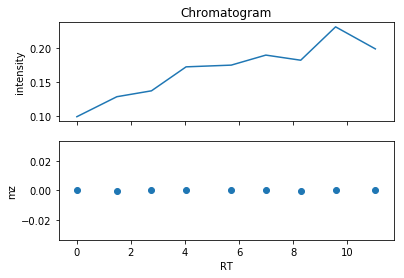

KnownChemical - 'C7H9NO4S' rt=351.85 max_intensity=469993.81
[382418.09375 454315.4375  420965.0625  469997.21875]


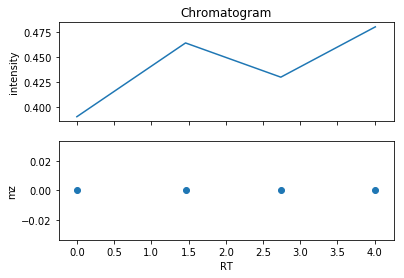

KnownChemical - 'C8H7NO4' rt=566.51 max_intensity=389080.54
[134724.28125   58167.640625 179537.03125  168567.1875   257554.9375
 268713.8125   201838.90625  248169.765625 238545.734375 234585.9375
 196785.53125  292764.4375   218297.96875  260477.75     219023.578125
 287010.1875   268130.8125    81165.421875 203169.890625 194503.765625
 246707.515625 199219.296875 237497.390625 255281.59375  389075.40625
 252639.5      248936.5625   248940.625    240076.8125    73086.84375 ]


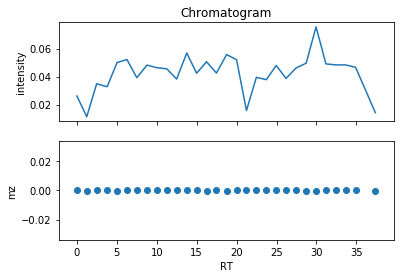

KnownChemical - 'C16H27N4O8P2S' rt=797.75 max_intensity=756473.81
[503442.96875 609718.6875  711696.5     756489.0625  698983.9375
 755297.3125  478203.9375 ]


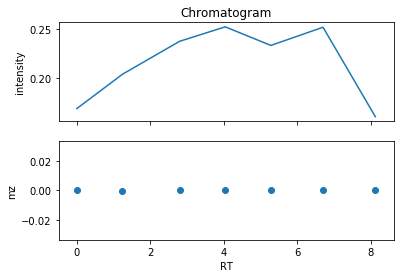

KnownChemical - 'C4H6O4S2' rt=520.79 max_intensity=290440.07
[ 73149.1015625 124448.0078125  45866.140625  290423.625
 163016.71875   138990.859375   62243.515625 ]


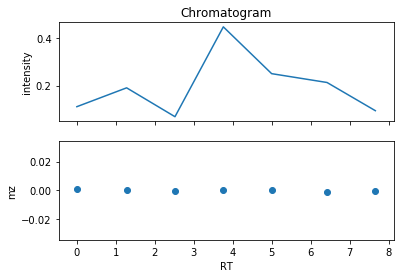

KnownChemical - 'C10H14N2O4' rt=355.47 max_intensity=666290.31
[ 18153.65429688  17772.89257812  26833.99023438  23390.22265625
  22984.3828125   28017.68164062  42923.05859375  64006.03125
  73072.6015625   55182.43359375  56804.20703125  97345.5546875
  92152.3125      88551.90625     82225.6796875  110188.6953125
  93634.625      145465.515625   220701.328125   160528.9375
 194974.9375     172957.421875   231025.1875     195670.140625
 240929.6875     289952.5        235838.65625    267493.03125
 275639.875      354640.8125     327368.1875     317700.
 329773.5625     353537.15625    337652.34375    368943.34375
 378423.875      374552.         292834.25       377370.75
 378317.6875     396188.         315947.03125    376292.78125
 416354.59375    541390.625      427205.84375    478019.1875
 666272.9375     435251.84375    534853.8125     470164.625
 507146.96875    564665.5625     536892.8125     465166.625
 594387.6875     473096.40625    509976.         511211.28125
 465677.875  

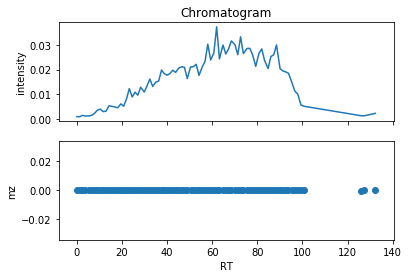

In [13]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in dataset[0:10]:
    print(chem)
    print(chem.chromatogram.raw_intensities)
    plot_chromatogram(chem.chromatogram)

### Set up a simple MS1 controller

In [16]:
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset, density=ps.density_estimator)
controller = SimpleMs1Controller(mass_spec)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(min_rt, max_rt)

INFO:SimpleMs1Controller:Acquisition open
INFO:SimpleMs1Controller:Received Scan 0 num_peaks=16 rt=180.00 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1 num_peaks=16 rt=180.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2 num_peaks=16 rt=180.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3 num_peaks=16 rt=180.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4 num_peaks=22 rt=180.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5 num_peaks=22 rt=180.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6 num_peaks=22 rt=180.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7 num_peaks=22 rt=180.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 8 num_peaks=22 rt=180.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 9 num_peaks=22 rt=180.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 10 num_peaks=22 rt=180.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 11 num_peaks=22 rt=181.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 12 num_peaks=28 r

INFO:SimpleMs1Controller:Received Scan 107 num_peaks=143 rt=193.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 108 num_peaks=143 rt=193.63 ms_level=1
INFO:SimpleMs1Controller:Received Scan 109 num_peaks=149 rt=193.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 110 num_peaks=149 rt=193.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 111 num_peaks=149 rt=193.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 112 num_peaks=137 rt=194.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 113 num_peaks=143 rt=194.11 ms_level=1
INFO:SimpleMs1Controller:Received Scan 114 num_peaks=149 rt=194.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 115 num_peaks=149 rt=194.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 116 num_peaks=149 rt=194.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 117 num_peaks=154 rt=194.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 118 num_peaks=160 rt=194.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 119 num_peaks=160 rt=195.

INFO:SimpleMs1Controller:Received Scan 213 num_peaks=161 rt=207.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 214 num_peaks=161 rt=207.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 215 num_peaks=161 rt=207.45 ms_level=1
INFO:SimpleMs1Controller:Received Scan 216 num_peaks=155 rt=207.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 217 num_peaks=160 rt=207.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 218 num_peaks=155 rt=207.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 219 num_peaks=161 rt=208.00 ms_level=1
INFO:SimpleMs1Controller:Received Scan 220 num_peaks=155 rt=208.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 221 num_peaks=150 rt=208.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 222 num_peaks=150 rt=208.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 223 num_peaks=150 rt=208.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 224 num_peaks=150 rt=208.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 225 num_peaks=150 rt=208.

INFO:SimpleMs1Controller:Received Scan 319 num_peaks=200 rt=220.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 320 num_peaks=205 rt=220.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 321 num_peaks=205 rt=220.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 322 num_peaks=205 rt=221.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 323 num_peaks=205 rt=221.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 324 num_peaks=205 rt=221.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 325 num_peaks=205 rt=221.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 326 num_peaks=205 rt=221.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 327 num_peaks=205 rt=221.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 328 num_peaks=211 rt=221.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 329 num_peaks=206 rt=221.84 ms_level=1
INFO:SimpleMs1Controller:Received Scan 330 num_peaks=206 rt=221.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 331 num_peaks=206 rt=221.

INFO:SimpleMs1Controller:Received Scan 425 num_peaks=211 rt=233.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 426 num_peaks=216 rt=233.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 427 num_peaks=216 rt=233.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 428 num_peaks=216 rt=233.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 429 num_peaks=210 rt=234.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 430 num_peaks=216 rt=234.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 431 num_peaks=216 rt=234.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 432 num_peaks=216 rt=234.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 433 num_peaks=216 rt=234.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 434 num_peaks=211 rt=234.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 435 num_peaks=211 rt=234.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 436 num_peaks=216 rt=234.73 ms_level=1
INFO:SimpleMs1Controller:Received Scan 437 num_peaks=216 rt=235.

INFO:SimpleMs1Controller:Received Scan 531 num_peaks=187 rt=248.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 532 num_peaks=187 rt=248.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 533 num_peaks=187 rt=248.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 534 num_peaks=187 rt=248.31 ms_level=1
INFO:SimpleMs1Controller:Received Scan 535 num_peaks=187 rt=248.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 536 num_peaks=187 rt=248.46 ms_level=1
INFO:SimpleMs1Controller:Received Scan 537 num_peaks=187 rt=248.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 538 num_peaks=187 rt=248.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 539 num_peaks=187 rt=248.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 540 num_peaks=187 rt=248.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 541 num_peaks=183 rt=249.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 542 num_peaks=183 rt=249.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 543 num_peaks=183 rt=249.

INFO:SimpleMs1Controller:Received Scan 637 num_peaks=217 rt=260.73 ms_level=1
INFO:SimpleMs1Controller:Received Scan 638 num_peaks=217 rt=260.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 639 num_peaks=217 rt=261.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 640 num_peaks=217 rt=261.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 641 num_peaks=223 rt=261.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 642 num_peaks=223 rt=261.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 643 num_peaks=219 rt=261.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 644 num_peaks=214 rt=261.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 645 num_peaks=208 rt=261.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 646 num_peaks=202 rt=261.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 647 num_peaks=202 rt=261.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 648 num_peaks=203 rt=262.11 ms_level=1
INFO:SimpleMs1Controller:Received Scan 649 num_peaks=203 rt=262.

INFO:SimpleMs1Controller:Received Scan 743 num_peaks=209 rt=274.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 744 num_peaks=209 rt=275.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 745 num_peaks=209 rt=275.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 746 num_peaks=208 rt=275.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 747 num_peaks=203 rt=275.60 ms_level=1
INFO:SimpleMs1Controller:Received Scan 748 num_peaks=203 rt=275.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 749 num_peaks=203 rt=275.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 750 num_peaks=203 rt=275.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 751 num_peaks=192 rt=276.00 ms_level=1
INFO:SimpleMs1Controller:Received Scan 752 num_peaks=192 rt=276.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 753 num_peaks=192 rt=276.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 754 num_peaks=198 rt=276.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 755 num_peaks=198 rt=276.

INFO:SimpleMs1Controller:Received Scan 849 num_peaks=191 rt=288.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 850 num_peaks=191 rt=288.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 851 num_peaks=191 rt=288.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 852 num_peaks=195 rt=288.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 853 num_peaks=195 rt=288.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 854 num_peaks=201 rt=288.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 855 num_peaks=201 rt=288.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 856 num_peaks=201 rt=289.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 857 num_peaks=201 rt=289.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 858 num_peaks=201 rt=289.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 859 num_peaks=201 rt=289.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 860 num_peaks=201 rt=289.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 861 num_peaks=201 rt=289.

INFO:SimpleMs1Controller:Received Scan 955 num_peaks=190 rt=300.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 956 num_peaks=190 rt=301.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 957 num_peaks=190 rt=301.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 958 num_peaks=190 rt=301.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 959 num_peaks=190 rt=301.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 960 num_peaks=195 rt=301.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 961 num_peaks=196 rt=301.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 962 num_peaks=196 rt=301.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 963 num_peaks=196 rt=301.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 964 num_peaks=191 rt=301.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 965 num_peaks=196 rt=302.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 966 num_peaks=196 rt=302.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 967 num_peaks=196 rt=302.

INFO:SimpleMs1Controller:Received Scan 1060 num_peaks=158 rt=313.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1061 num_peaks=164 rt=313.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1062 num_peaks=164 rt=313.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1063 num_peaks=159 rt=314.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1064 num_peaks=159 rt=314.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1065 num_peaks=159 rt=314.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1066 num_peaks=159 rt=314.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1067 num_peaks=153 rt=314.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1068 num_peaks=164 rt=314.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1069 num_peaks=164 rt=314.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1070 num_peaks=164 rt=315.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1071 num_peaks=164 rt=315.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1072 num_peak

INFO:SimpleMs1Controller:Received Scan 1164 num_peaks=235 rt=326.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1165 num_peaks=234 rt=326.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1166 num_peaks=234 rt=326.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1167 num_peaks=234 rt=327.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1168 num_peaks=234 rt=327.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1169 num_peaks=228 rt=327.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1170 num_peaks=233 rt=327.53 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1171 num_peaks=255 rt=327.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1172 num_peaks=249 rt=328.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1173 num_peaks=254 rt=328.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1174 num_peaks=254 rt=328.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1175 num_peaks=254 rt=328.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1176 num_peak

INFO:SimpleMs1Controller:Received Scan 1268 num_peaks=213 rt=339.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1269 num_peaks=214 rt=339.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1270 num_peaks=214 rt=339.63 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1271 num_peaks=210 rt=339.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1272 num_peaks=210 rt=340.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1273 num_peaks=210 rt=340.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1274 num_peaks=210 rt=340.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1275 num_peaks=210 rt=340.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1276 num_peaks=210 rt=340.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1277 num_peaks=205 rt=340.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1278 num_peaks=205 rt=340.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1279 num_peaks=205 rt=341.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1280 num_peak

INFO:SimpleMs1Controller:Received Scan 1372 num_peaks=229 rt=353.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1373 num_peaks=229 rt=353.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1374 num_peaks=229 rt=353.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1375 num_peaks=229 rt=353.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1376 num_peaks=229 rt=353.68 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1377 num_peaks=229 rt=353.73 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1378 num_peaks=229 rt=353.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1379 num_peaks=229 rt=354.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1380 num_peaks=229 rt=354.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1381 num_peaks=229 rt=354.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1382 num_peaks=229 rt=354.31 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1383 num_peaks=233 rt=354.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1384 num_peak

INFO:SimpleMs1Controller:Received Scan 1476 num_peaks=284 rt=366.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1477 num_peaks=290 rt=367.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1478 num_peaks=285 rt=367.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1479 num_peaks=285 rt=367.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1480 num_peaks=285 rt=367.45 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1481 num_peaks=285 rt=367.53 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1482 num_peaks=285 rt=367.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1483 num_peaks=285 rt=368.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1484 num_peaks=296 rt=368.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1485 num_peaks=291 rt=368.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1486 num_peaks=280 rt=368.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1487 num_peaks=280 rt=368.46 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1488 num_peak

INFO:SimpleMs1Controller:Received Scan 1580 num_peaks=330 rt=380.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1581 num_peaks=330 rt=381.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1582 num_peaks=330 rt=381.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1583 num_peaks=330 rt=381.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1584 num_peaks=330 rt=381.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1585 num_peaks=330 rt=382.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1586 num_peaks=330 rt=382.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1587 num_peaks=330 rt=382.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1588 num_peaks=325 rt=382.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1589 num_peaks=336 rt=382.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1590 num_peaks=342 rt=382.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1591 num_peaks=334 rt=383.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1592 num_peak

INFO:SimpleMs1Controller:Received Scan 1684 num_peaks=359 rt=395.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1685 num_peaks=359 rt=395.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1686 num_peaks=359 rt=396.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1687 num_peaks=359 rt=396.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1688 num_peaks=359 rt=396.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1689 num_peaks=359 rt=396.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1690 num_peaks=359 rt=396.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1691 num_peaks=354 rt=396.46 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1692 num_peaks=354 rt=396.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1693 num_peaks=354 rt=396.68 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1694 num_peaks=359 rt=396.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1695 num_peaks=362 rt=396.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1696 num_peak

INFO:SimpleMs1Controller:Received Scan 1788 num_peaks=306 rt=408.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1789 num_peaks=300 rt=408.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1790 num_peaks=301 rt=408.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1791 num_peaks=296 rt=409.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1792 num_peaks=301 rt=409.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1793 num_peaks=306 rt=409.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1794 num_peaks=306 rt=409.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1795 num_peaks=305 rt=409.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1796 num_peaks=305 rt=409.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1797 num_peaks=300 rt=409.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1798 num_peaks=305 rt=409.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1799 num_peaks=310 rt=409.99 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1800 num_peak

INFO:SimpleMs1Controller:Received Scan 1892 num_peaks=321 rt=421.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1893 num_peaks=328 rt=421.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1894 num_peaks=334 rt=422.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1895 num_peaks=334 rt=422.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1896 num_peaks=328 rt=422.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1897 num_peaks=328 rt=422.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1898 num_peaks=322 rt=422.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1899 num_peaks=322 rt=422.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1900 num_peaks=322 rt=422.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1901 num_peaks=317 rt=422.63 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1902 num_peaks=322 rt=422.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1903 num_peaks=322 rt=422.84 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1904 num_peak

INFO:SimpleMs1Controller:Received Scan 1996 num_peaks=327 rt=434.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1997 num_peaks=327 rt=434.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1998 num_peaks=327 rt=434.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1999 num_peaks=327 rt=435.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2000 num_peaks=327 rt=435.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2001 num_peaks=322 rt=435.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2002 num_peaks=322 rt=435.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2003 num_peaks=322 rt=435.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2004 num_peaks=316 rt=435.60 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2005 num_peaks=316 rt=435.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2006 num_peaks=316 rt=435.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2007 num_peaks=316 rt=435.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2008 num_peak

INFO:SimpleMs1Controller:Received Scan 2100 num_peaks=253 rt=446.79 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2101 num_peaks=247 rt=446.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2102 num_peaks=247 rt=447.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2103 num_peaks=247 rt=447.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2104 num_peaks=252 rt=447.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2105 num_peaks=247 rt=447.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2106 num_peaks=241 rt=447.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2107 num_peaks=241 rt=447.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2108 num_peaks=241 rt=447.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2109 num_peaks=258 rt=448.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2110 num_peaks=258 rt=448.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2111 num_peaks=258 rt=448.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2112 num_peak

INFO:SimpleMs1Controller:Received Scan 2204 num_peaks=352 rt=460.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2205 num_peaks=358 rt=460.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2206 num_peaks=358 rt=460.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2207 num_peaks=358 rt=461.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2208 num_peaks=364 rt=461.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2209 num_peaks=369 rt=461.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2210 num_peaks=369 rt=461.53 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2211 num_peaks=369 rt=461.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2212 num_peaks=369 rt=461.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2213 num_peaks=369 rt=461.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2214 num_peaks=374 rt=461.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2215 num_peaks=374 rt=462.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2216 num_peak

INFO:SimpleMs1Controller:Received Scan 2308 num_peaks=438 rt=474.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2309 num_peaks=438 rt=474.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2310 num_peaks=432 rt=474.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2311 num_peaks=432 rt=474.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2312 num_peaks=432 rt=474.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2313 num_peaks=432 rt=474.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2314 num_peaks=432 rt=474.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2315 num_peaks=432 rt=474.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2316 num_peaks=426 rt=475.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2317 num_peaks=438 rt=475.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2318 num_peaks=438 rt=475.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2319 num_peaks=432 rt=475.58 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2320 num_peak

INFO:SimpleMs1Controller:Received Scan 2412 num_peaks=429 rt=487.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2413 num_peaks=417 rt=487.31 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2414 num_peaks=422 rt=487.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2415 num_peaks=422 rt=487.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2416 num_peaks=428 rt=487.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2417 num_peaks=423 rt=487.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2418 num_peaks=423 rt=487.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2419 num_peaks=411 rt=488.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2420 num_peaks=405 rt=488.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2421 num_peaks=405 rt=488.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2422 num_peaks=394 rt=488.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2423 num_peaks=400 rt=488.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2424 num_peak

INFO:SimpleMs1Controller:Received Scan 2516 num_peaks=280 rt=500.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2517 num_peaks=274 rt=500.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2518 num_peaks=274 rt=500.45 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2519 num_peaks=280 rt=500.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2520 num_peaks=271 rt=500.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2521 num_peaks=271 rt=500.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2522 num_peaks=271 rt=500.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2523 num_peaks=283 rt=501.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2524 num_peaks=289 rt=501.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2525 num_peaks=301 rt=501.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2526 num_peaks=301 rt=501.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2527 num_peaks=301 rt=501.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2528 num_peak

INFO:SimpleMs1Controller:Received Scan 2620 num_peaks=357 rt=514.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2621 num_peaks=352 rt=515.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2622 num_peaks=358 rt=515.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2623 num_peaks=358 rt=515.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2624 num_peaks=358 rt=515.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2625 num_peaks=347 rt=515.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2626 num_peaks=329 rt=516.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2627 num_peaks=329 rt=516.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2628 num_peaks=329 rt=516.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2629 num_peaks=323 rt=516.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2630 num_peaks=323 rt=516.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2631 num_peaks=317 rt=516.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2632 num_peak

INFO:SimpleMs1Controller:Received Scan 2724 num_peaks=182 rt=529.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2725 num_peaks=182 rt=529.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2726 num_peaks=182 rt=530.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2727 num_peaks=182 rt=530.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2728 num_peaks=182 rt=530.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2729 num_peaks=182 rt=530.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2730 num_peaks=182 rt=530.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2731 num_peaks=182 rt=530.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2732 num_peaks=182 rt=530.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2733 num_peaks=188 rt=530.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2734 num_peaks=182 rt=530.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2735 num_peaks=182 rt=530.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2736 num_peak

INFO:SimpleMs1Controller:Received Scan 2828 num_peaks=153 rt=542.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2829 num_peaks=153 rt=542.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2830 num_peaks=153 rt=542.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2831 num_peaks=158 rt=542.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2832 num_peaks=163 rt=542.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2833 num_peaks=151 rt=543.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2834 num_peaks=156 rt=543.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2835 num_peaks=156 rt=543.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2836 num_peaks=156 rt=543.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2837 num_peaks=156 rt=543.63 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2838 num_peaks=156 rt=543.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2839 num_peaks=161 rt=543.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2840 num_peak

INFO:SimpleMs1Controller:Received Scan 2932 num_peaks=216 rt=556.53 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2933 num_peaks=216 rt=556.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2934 num_peaks=222 rt=556.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2935 num_peaks=228 rt=556.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2936 num_peaks=228 rt=557.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2937 num_peaks=228 rt=557.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2938 num_peaks=228 rt=557.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2939 num_peaks=233 rt=557.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2940 num_peaks=228 rt=557.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2941 num_peaks=233 rt=557.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2942 num_peaks=233 rt=557.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2943 num_peaks=233 rt=558.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 2944 num_peak

INFO:SimpleMs1Controller:Received Scan 3036 num_peaks=239 rt=569.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3037 num_peaks=245 rt=569.45 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3038 num_peaks=245 rt=569.58 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3039 num_peaks=240 rt=569.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3040 num_peaks=234 rt=569.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3041 num_peaks=234 rt=569.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3042 num_peaks=234 rt=569.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3043 num_peaks=234 rt=569.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3044 num_peaks=229 rt=570.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3045 num_peaks=223 rt=570.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3046 num_peaks=222 rt=570.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3047 num_peaks=216 rt=570.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3048 num_peak

INFO:SimpleMs1Controller:Received Scan 3140 num_peaks=206 rt=581.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3141 num_peaks=206 rt=581.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3142 num_peaks=206 rt=581.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3143 num_peaks=206 rt=581.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3144 num_peaks=206 rt=582.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3145 num_peaks=206 rt=582.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3146 num_peaks=206 rt=582.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3147 num_peaks=212 rt=582.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3148 num_peaks=212 rt=582.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3149 num_peaks=212 rt=582.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3150 num_peaks=219 rt=582.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3151 num_peaks=219 rt=582.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3152 num_peak

INFO:SimpleMs1Controller:Received Scan 3244 num_peaks=253 rt=595.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3245 num_peaks=258 rt=595.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3246 num_peaks=252 rt=595.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3247 num_peaks=252 rt=595.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3248 num_peaks=246 rt=595.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3249 num_peaks=246 rt=595.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3250 num_peaks=246 rt=596.11 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3251 num_peaks=246 rt=596.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3252 num_peaks=246 rt=596.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3253 num_peaks=252 rt=596.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3254 num_peaks=252 rt=596.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3255 num_peaks=252 rt=596.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3256 num_peak

INFO:SimpleMs1Controller:Received Scan 3348 num_peaks=260 rt=607.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3349 num_peaks=265 rt=607.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3350 num_peaks=259 rt=607.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3351 num_peaks=259 rt=607.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3352 num_peaks=259 rt=607.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3353 num_peaks=269 rt=608.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3354 num_peaks=268 rt=608.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3355 num_peaks=268 rt=608.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3356 num_peaks=267 rt=608.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3357 num_peaks=261 rt=608.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3358 num_peaks=261 rt=608.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3359 num_peaks=267 rt=609.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3360 num_peak

INFO:SimpleMs1Controller:Received Scan 3452 num_peaks=217 rt=619.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3453 num_peaks=212 rt=619.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3454 num_peaks=212 rt=619.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3455 num_peaks=218 rt=620.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3456 num_peaks=212 rt=620.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3457 num_peaks=212 rt=620.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3458 num_peaks=217 rt=620.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3459 num_peaks=217 rt=620.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3460 num_peaks=217 rt=620.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3461 num_peaks=212 rt=620.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3462 num_peaks=202 rt=620.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3463 num_peaks=207 rt=621.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3464 num_peak

INFO:SimpleMs1Controller:Received Scan 3556 num_peaks=224 rt=633.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3557 num_peaks=223 rt=633.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3558 num_peaks=218 rt=633.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3559 num_peaks=218 rt=633.66 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3560 num_peaks=212 rt=633.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3561 num_peaks=207 rt=634.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3562 num_peaks=202 rt=634.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3563 num_peaks=202 rt=634.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3564 num_peaks=202 rt=634.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3565 num_peaks=207 rt=634.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3566 num_peaks=207 rt=634.58 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3567 num_peaks=207 rt=634.66 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3568 num_peak

INFO:SimpleMs1Controller:Received Scan 3660 num_peaks=190 rt=646.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3661 num_peaks=195 rt=646.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3662 num_peaks=195 rt=646.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3663 num_peaks=195 rt=646.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3664 num_peaks=189 rt=646.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3665 num_peaks=189 rt=646.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3666 num_peaks=189 rt=646.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3667 num_peaks=189 rt=647.11 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3668 num_peaks=179 rt=647.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3669 num_peaks=179 rt=647.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3670 num_peaks=184 rt=647.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3671 num_peaks=184 rt=647.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3672 num_peak

INFO:SimpleMs1Controller:Received Scan 3764 num_peaks=215 rt=659.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3765 num_peaks=204 rt=660.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3766 num_peaks=204 rt=660.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3767 num_peaks=198 rt=660.30 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3768 num_peaks=198 rt=660.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3769 num_peaks=192 rt=660.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3770 num_peaks=192 rt=660.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3771 num_peaks=187 rt=661.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3772 num_peaks=181 rt=661.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3773 num_peaks=191 rt=661.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3774 num_peaks=191 rt=661.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3775 num_peaks=191 rt=661.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3776 num_peak

INFO:SimpleMs1Controller:Received Scan 3868 num_peaks=254 rt=672.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3869 num_peaks=255 rt=672.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3870 num_peaks=261 rt=672.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3871 num_peaks=266 rt=673.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3872 num_peaks=266 rt=673.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3873 num_peaks=266 rt=673.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3874 num_peaks=266 rt=673.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3875 num_peaks=266 rt=673.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3876 num_peaks=266 rt=674.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3877 num_peaks=265 rt=674.31 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3878 num_peaks=258 rt=674.45 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3879 num_peaks=258 rt=674.58 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3880 num_peak

INFO:SimpleMs1Controller:Received Scan 3972 num_peaks=223 rt=685.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3973 num_peaks=229 rt=685.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3974 num_peaks=229 rt=686.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3975 num_peaks=229 rt=686.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3976 num_peaks=229 rt=686.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3977 num_peaks=229 rt=686.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3978 num_peaks=229 rt=686.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3979 num_peaks=229 rt=686.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3980 num_peaks=224 rt=686.66 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3981 num_peaks=218 rt=686.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3982 num_peaks=224 rt=687.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3983 num_peaks=219 rt=687.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 3984 num_peak

INFO:SimpleMs1Controller:Received Scan 4076 num_peaks=213 rt=697.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4077 num_peaks=208 rt=697.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4078 num_peaks=197 rt=697.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4079 num_peaks=197 rt=697.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4080 num_peaks=203 rt=697.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4081 num_peaks=193 rt=698.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4082 num_peaks=183 rt=698.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4083 num_peaks=183 rt=698.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4084 num_peaks=178 rt=698.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4085 num_peaks=178 rt=698.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4086 num_peaks=188 rt=698.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4087 num_peaks=182 rt=698.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4088 num_peak

INFO:SimpleMs1Controller:Received Scan 4180 num_peaks=234 rt=710.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4181 num_peaks=234 rt=710.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4182 num_peaks=239 rt=710.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4183 num_peaks=245 rt=710.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4184 num_peaks=250 rt=711.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4185 num_peaks=245 rt=711.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4186 num_peaks=245 rt=711.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4187 num_peaks=240 rt=711.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4188 num_peaks=245 rt=711.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4189 num_peaks=245 rt=711.73 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4190 num_peaks=245 rt=711.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4191 num_peaks=240 rt=712.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4192 num_peak

INFO:SimpleMs1Controller:Received Scan 4284 num_peaks=278 rt=724.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4285 num_peaks=278 rt=724.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4286 num_peaks=278 rt=725.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4287 num_peaks=284 rt=725.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4288 num_peaks=284 rt=725.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4289 num_peaks=284 rt=725.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4290 num_peaks=284 rt=725.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4291 num_peaks=279 rt=725.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4292 num_peaks=279 rt=726.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4293 num_peaks=284 rt=726.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4294 num_peaks=279 rt=726.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4295 num_peaks=279 rt=726.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4296 num_peak

INFO:SimpleMs1Controller:Received Scan 4388 num_peaks=244 rt=738.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4389 num_peaks=244 rt=738.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4390 num_peaks=244 rt=738.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4391 num_peaks=244 rt=738.46 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4392 num_peaks=249 rt=738.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4393 num_peaks=249 rt=738.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4394 num_peaks=249 rt=738.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4395 num_peaks=249 rt=738.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4396 num_peaks=249 rt=738.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4397 num_peaks=249 rt=738.99 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4398 num_peaks=249 rt=739.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4399 num_peaks=249 rt=739.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4400 num_peak

INFO:SimpleMs1Controller:Received Scan 4492 num_peaks=260 rt=751.11 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4493 num_peaks=260 rt=751.17 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4494 num_peaks=260 rt=751.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4495 num_peaks=259 rt=751.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4496 num_peaks=270 rt=751.99 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4497 num_peaks=276 rt=752.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4498 num_peaks=276 rt=752.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4499 num_peaks=281 rt=752.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4500 num_peaks=276 rt=752.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4501 num_peaks=276 rt=752.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4502 num_peaks=276 rt=752.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4503 num_peaks=276 rt=752.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4504 num_peak

INFO:SimpleMs1Controller:Received Scan 4596 num_peaks=259 rt=764.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4597 num_peaks=254 rt=764.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4598 num_peaks=254 rt=764.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4599 num_peaks=254 rt=765.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4600 num_peaks=264 rt=765.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4601 num_peaks=269 rt=765.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4602 num_peaks=278 rt=765.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4603 num_peaks=278 rt=765.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4604 num_peaks=278 rt=766.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4605 num_peaks=278 rt=766.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4606 num_peaks=283 rt=766.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4607 num_peaks=283 rt=766.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4608 num_peak

INFO:SimpleMs1Controller:Received Scan 4700 num_peaks=260 rt=778.84 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4701 num_peaks=260 rt=778.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4702 num_peaks=260 rt=779.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4703 num_peaks=260 rt=779.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4704 num_peaks=272 rt=779.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4705 num_peaks=272 rt=779.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4706 num_peaks=266 rt=779.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4707 num_peaks=266 rt=779.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4708 num_peaks=266 rt=779.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4709 num_peaks=261 rt=779.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4710 num_peaks=261 rt=779.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4711 num_peaks=256 rt=780.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4712 num_peak

INFO:SimpleMs1Controller:Received Scan 4804 num_peaks=247 rt=792.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4805 num_peaks=247 rt=792.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4806 num_peaks=254 rt=792.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4807 num_peaks=254 rt=792.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4808 num_peaks=259 rt=792.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4809 num_peaks=259 rt=792.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4810 num_peaks=259 rt=793.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4811 num_peaks=259 rt=793.30 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4812 num_peaks=259 rt=793.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4813 num_peaks=259 rt=793.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4814 num_peaks=259 rt=793.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4815 num_peaks=259 rt=793.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4816 num_peak

INFO:SimpleMs1Controller:Received Scan 4908 num_peaks=297 rt=805.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4909 num_peaks=291 rt=805.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4910 num_peaks=291 rt=805.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4911 num_peaks=297 rt=805.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4912 num_peaks=297 rt=805.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4913 num_peaks=297 rt=805.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4914 num_peaks=297 rt=805.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4915 num_peaks=297 rt=805.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4916 num_peaks=297 rt=805.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4917 num_peaks=286 rt=806.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4918 num_peaks=291 rt=806.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4919 num_peaks=286 rt=806.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 4920 num_peak

INFO:SimpleMs1Controller:Received Scan 5012 num_peaks=285 rt=818.79 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5013 num_peaks=285 rt=818.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5014 num_peaks=279 rt=819.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5015 num_peaks=285 rt=819.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5016 num_peaks=290 rt=819.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5017 num_peaks=290 rt=819.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5018 num_peaks=290 rt=819.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5019 num_peaks=290 rt=819.73 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5020 num_peaks=290 rt=819.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5021 num_peaks=290 rt=820.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5022 num_peaks=290 rt=820.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5023 num_peaks=286 rt=820.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5024 num_peak

INFO:SimpleMs1Controller:Received Scan 5116 num_peaks=323 rt=832.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5117 num_peaks=323 rt=832.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5118 num_peaks=318 rt=832.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5119 num_peaks=318 rt=832.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5120 num_peaks=318 rt=833.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5121 num_peaks=312 rt=833.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5122 num_peaks=307 rt=833.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5123 num_peaks=301 rt=833.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5124 num_peaks=301 rt=833.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5125 num_peaks=301 rt=833.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5126 num_peaks=301 rt=833.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5127 num_peaks=296 rt=834.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5128 num_peak

INFO:SimpleMs1Controller:Received Scan 5220 num_peaks=290 rt=848.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5221 num_peaks=290 rt=848.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5222 num_peaks=295 rt=848.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5223 num_peaks=289 rt=848.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5224 num_peaks=289 rt=849.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5225 num_peaks=289 rt=849.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5226 num_peaks=283 rt=849.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5227 num_peaks=283 rt=849.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5228 num_peaks=289 rt=849.42 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5229 num_peaks=294 rt=849.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5230 num_peaks=294 rt=849.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5231 num_peaks=294 rt=849.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5232 num_peak

INFO:SimpleMs1Controller:Received Scan 5324 num_peaks=265 rt=860.99 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5325 num_peaks=265 rt=861.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5326 num_peaks=270 rt=861.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5327 num_peaks=265 rt=861.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5328 num_peaks=259 rt=861.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5329 num_peaks=259 rt=861.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5330 num_peaks=259 rt=861.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5331 num_peaks=259 rt=861.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5332 num_peaks=259 rt=862.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5333 num_peaks=259 rt=862.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5334 num_peaks=259 rt=862.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5335 num_peaks=259 rt=862.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5336 num_peak

INFO:SimpleMs1Controller:Received Scan 5428 num_peaks=348 rt=873.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5429 num_peaks=348 rt=874.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5430 num_peaks=348 rt=874.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5431 num_peaks=354 rt=874.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5432 num_peaks=354 rt=874.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5433 num_peaks=354 rt=874.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5434 num_peaks=359 rt=874.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5435 num_peaks=359 rt=874.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5436 num_peaks=359 rt=874.59 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5437 num_peaks=359 rt=874.66 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5438 num_peaks=359 rt=874.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5439 num_peaks=353 rt=874.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5440 num_peak

INFO:SimpleMs1Controller:Received Scan 5532 num_peaks=247 rt=887.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5533 num_peaks=236 rt=887.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5534 num_peaks=236 rt=888.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5535 num_peaks=236 rt=888.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5536 num_peaks=236 rt=888.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5537 num_peaks=236 rt=888.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5538 num_peaks=236 rt=888.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5539 num_peaks=236 rt=888.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5540 num_peaks=236 rt=888.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5541 num_peaks=236 rt=888.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5542 num_peaks=236 rt=888.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5543 num_peaks=236 rt=889.05 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5544 num_peak

INFO:SimpleMs1Controller:Received Scan 5636 num_peaks=260 rt=900.32 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5637 num_peaks=260 rt=900.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5638 num_peaks=254 rt=900.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5639 num_peaks=254 rt=900.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5640 num_peaks=254 rt=900.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5641 num_peaks=254 rt=900.91 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5642 num_peaks=254 rt=900.98 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5643 num_peaks=265 rt=901.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5644 num_peaks=260 rt=901.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5645 num_peaks=266 rt=901.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5646 num_peaks=266 rt=901.83 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5647 num_peaks=266 rt=901.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5648 num_peak

INFO:SimpleMs1Controller:Received Scan 5740 num_peaks=294 rt=913.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5741 num_peaks=294 rt=913.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5742 num_peaks=294 rt=913.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5743 num_peaks=294 rt=913.68 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5744 num_peaks=294 rt=913.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5745 num_peaks=288 rt=913.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5746 num_peaks=294 rt=914.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5747 num_peaks=294 rt=914.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5748 num_peaks=288 rt=914.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5749 num_peaks=283 rt=914.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5750 num_peaks=283 rt=914.79 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5751 num_peaks=294 rt=914.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5752 num_peak

INFO:SimpleMs1Controller:Received Scan 5844 num_peaks=256 rt=927.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5845 num_peaks=256 rt=927.29 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5846 num_peaks=256 rt=927.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5847 num_peaks=250 rt=927.47 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5848 num_peaks=250 rt=927.55 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5849 num_peaks=244 rt=927.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5850 num_peaks=244 rt=928.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5851 num_peaks=250 rt=928.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5852 num_peaks=244 rt=928.35 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5853 num_peaks=244 rt=928.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5854 num_peaks=244 rt=928.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5855 num_peaks=244 rt=928.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5856 num_peak

INFO:SimpleMs1Controller:Received Scan 5948 num_peaks=174 rt=940.67 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5949 num_peaks=168 rt=940.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5950 num_peaks=168 rt=940.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5951 num_peaks=168 rt=941.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5952 num_peaks=163 rt=941.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5953 num_peaks=169 rt=941.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5954 num_peaks=174 rt=941.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5955 num_peaks=168 rt=941.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5956 num_peaks=185 rt=941.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5957 num_peaks=185 rt=942.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5958 num_peaks=179 rt=942.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5959 num_peaks=179 rt=942.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 5960 num_peak

INFO:SimpleMs1Controller:Received Scan 6052 num_peaks=159 rt=954.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6053 num_peaks=159 rt=954.30 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6054 num_peaks=164 rt=954.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6055 num_peaks=169 rt=954.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6056 num_peaks=164 rt=954.63 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6057 num_peaks=164 rt=954.78 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6058 num_peaks=164 rt=954.84 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6059 num_peaks=164 rt=954.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6060 num_peaks=170 rt=955.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6061 num_peaks=170 rt=955.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6062 num_peaks=170 rt=955.23 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6063 num_peaks=176 rt=955.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6064 num_peak

INFO:SimpleMs1Controller:Received Scan 6156 num_peaks=227 rt=966.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6157 num_peaks=233 rt=966.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6158 num_peaks=233 rt=966.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6159 num_peaks=233 rt=966.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6160 num_peaks=239 rt=967.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6161 num_peaks=245 rt=967.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6162 num_peaks=245 rt=967.24 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6163 num_peaks=245 rt=967.30 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6164 num_peaks=245 rt=967.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6165 num_peaks=245 rt=967.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6166 num_peaks=245 rt=967.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6167 num_peaks=245 rt=967.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6168 num_peak

INFO:SimpleMs1Controller:Received Scan 6260 num_peaks=261 rt=979.06 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6261 num_peaks=261 rt=979.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6262 num_peaks=267 rt=979.39 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6263 num_peaks=267 rt=979.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6264 num_peaks=273 rt=979.64 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6265 num_peaks=273 rt=979.70 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6266 num_peaks=273 rt=980.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6267 num_peaks=273 rt=980.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6268 num_peaks=273 rt=980.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6269 num_peaks=273 rt=980.34 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6270 num_peaks=267 rt=980.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6271 num_peaks=267 rt=980.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6272 num_peak

INFO:SimpleMs1Controller:Received Scan 6364 num_peaks=236 rt=993.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6365 num_peaks=236 rt=993.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6366 num_peaks=236 rt=993.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6367 num_peaks=236 rt=993.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6368 num_peaks=236 rt=993.44 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6369 num_peaks=230 rt=993.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6370 num_peaks=225 rt=993.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6371 num_peaks=225 rt=993.97 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6372 num_peaks=225 rt=994.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6373 num_peaks=225 rt=994.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6374 num_peaks=219 rt=994.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6375 num_peaks=219 rt=994.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6376 num_peak

INFO:SimpleMs1Controller:Received Scan 6468 num_peaks=149 rt=1005.84 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6469 num_peaks=149 rt=1005.90 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6470 num_peaks=144 rt=1006.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6471 num_peaks=144 rt=1006.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6472 num_peaks=133 rt=1006.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6473 num_peaks=127 rt=1006.54 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6474 num_peaks=127 rt=1006.60 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6475 num_peaks=122 rt=1006.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6476 num_peaks=122 rt=1006.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6477 num_peaks=122 rt=1006.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6478 num_peaks=122 rt=1007.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6479 num_peaks=116 rt=1007.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6

INFO:SimpleMs1Controller:Received Scan 6572 num_peaks=54 rt=1019.14 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6573 num_peaks=54 rt=1019.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6574 num_peaks=54 rt=1019.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6575 num_peaks=54 rt=1019.66 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6576 num_peaks=54 rt=1019.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6577 num_peaks=54 rt=1019.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6578 num_peaks=54 rt=1019.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6579 num_peaks=54 rt=1020.00 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6580 num_peaks=54 rt=1020.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6581 num_peaks=54 rt=1020.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6582 num_peaks=54 rt=1020.31 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6583 num_peaks=54 rt=1020.38 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6584 num_peak

INFO:SimpleMs1Controller:Received Scan 6676 num_peaks=30 rt=1031.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6677 num_peaks=30 rt=1031.25 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6678 num_peaks=30 rt=1031.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6679 num_peaks=30 rt=1031.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6680 num_peaks=30 rt=1031.62 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6681 num_peaks=30 rt=1031.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6682 num_peaks=30 rt=1031.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6683 num_peaks=30 rt=1031.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6684 num_peaks=30 rt=1032.02 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6685 num_peaks=30 rt=1032.10 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6686 num_peaks=30 rt=1032.16 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6687 num_peaks=30 rt=1032.22 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6688 num_peak

INFO:SimpleMs1Controller:Received Scan 6780 num_peaks=30 rt=1044.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6781 num_peaks=30 rt=1044.99 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6782 num_peaks=30 rt=1045.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6783 num_peaks=30 rt=1045.21 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6784 num_peaks=30 rt=1045.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6785 num_peaks=30 rt=1045.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6786 num_peaks=30 rt=1045.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6787 num_peaks=30 rt=1045.58 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6788 num_peaks=30 rt=1045.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6789 num_peaks=30 rt=1045.82 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6790 num_peaks=30 rt=1046.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6791 num_peaks=30 rt=1046.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6792 num_peak

INFO:SimpleMs1Controller:Received Scan 6884 num_peaks=17 rt=1058.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6885 num_peaks=17 rt=1058.89 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6886 num_peaks=17 rt=1058.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6887 num_peaks=17 rt=1059.03 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6888 num_peaks=17 rt=1059.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6889 num_peaks=17 rt=1059.19 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6890 num_peaks=17 rt=1059.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6891 num_peaks=17 rt=1059.41 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6892 num_peaks=17 rt=1059.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6893 num_peaks=17 rt=1059.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6894 num_peaks=17 rt=1059.72 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6895 num_peaks=17 rt=1059.80 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6896 num_peak

INFO:SimpleMs1Controller:Received Scan 6988 num_peaks=17 rt=1072.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6989 num_peaks=17 rt=1073.08 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6990 num_peaks=17 rt=1073.18 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6991 num_peaks=17 rt=1073.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6992 num_peaks=17 rt=1073.49 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6993 num_peaks=17 rt=1073.76 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6994 num_peaks=17 rt=1073.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6995 num_peaks=17 rt=1073.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6996 num_peaks=17 rt=1074.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6997 num_peaks=17 rt=1074.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6998 num_peaks=17 rt=1074.28 ms_level=1
INFO:SimpleMs1Controller:Received Scan 6999 num_peaks=17 rt=1074.37 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7000 num_peak

INFO:SimpleMs1Controller:Received Scan 7092 num_peaks=11 rt=1086.51 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7093 num_peaks=11 rt=1086.79 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7094 num_peaks=11 rt=1086.87 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7095 num_peaks=11 rt=1086.92 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7096 num_peaks=11 rt=1087.04 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7097 num_peaks=11 rt=1087.12 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7098 num_peaks=11 rt=1087.20 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7099 num_peaks=11 rt=1087.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7100 num_peaks=11 rt=1087.40 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7101 num_peaks=11 rt=1087.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7102 num_peaks=11 rt=1087.56 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7103 num_peaks=11 rt=1087.65 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7104 num_peak

INFO:SimpleMs1Controller:Received Scan 7197 num_peaks=6 rt=1099.96 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7198 num_peaks=6 rt=1100.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7199 num_peaks=6 rt=1100.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7200 num_peaks=6 rt=1100.61 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7201 num_peaks=6 rt=1100.75 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7202 num_peaks=6 rt=1101.09 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7203 num_peaks=6 rt=1101.26 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7204 num_peaks=6 rt=1101.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7205 num_peaks=6 rt=1101.69 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7206 num_peaks=6 rt=1101.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7207 num_peaks=6 rt=1101.94 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7208 num_peaks=6 rt=1102.13 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7209 num_peaks=6 rt=1102.

INFO:SimpleMs1Controller:Received Scan 7303 num_peaks=6 rt=1113.77 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7304 num_peaks=6 rt=1113.85 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7305 num_peaks=6 rt=1114.00 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7306 num_peaks=6 rt=1114.07 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7307 num_peaks=6 rt=1114.15 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7308 num_peaks=6 rt=1114.33 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7309 num_peaks=6 rt=1114.48 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7310 num_peaks=6 rt=1114.57 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7311 num_peaks=6 rt=1114.74 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7312 num_peaks=6 rt=1114.81 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7313 num_peaks=6 rt=1114.88 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7314 num_peaks=6 rt=1114.95 ms_level=1
INFO:SimpleMs1Controller:Received Scan 7315 num_peaks=6 rt=1115.

In [17]:
controller.write_mzML('my_analysis', '../models/out.mzML')

### Set up a Top-N controller

In [ ]:
max_rt = 1000                    # the maximum retention time of scans to generate
N = 5                           # top-5 DDA fragmentation
mz_tol = 5                      # the mz isolation window around a selected precursor ion
rt_tol = 15                     # the rt window around a selected precursor ion to prevent it from fragmented multiple times
min_ms2_intensity = 5000        # the minimum ms2 peak intensity

In [ ]:
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals, density=ps.density_estimator)
controller = TopNController(mass_spec, N, mz_tol, rt_tol, min_ms2_intensity=min_ms2_intensity)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(min_rt, max_rt)

In [ ]:
controller.write_mzML('my_analysis', '../models/out.mzML')

### Set up a DIA controller

In [ ]:
max_rt = 1000
dia_design = "basic"
window_type = "even"
kaufmann_design = None
extra_bins = 0
num_windows = 10

In [ ]:
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals, density=ps.density_estimator)
controller = TreeController(mass_spec, dia_design, window_type, kaufmann_design, extra_bins, num_windows)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(min_rt, max_rt)

In [ ]:
controller.write_mzML('my_analysis', '../models/out.mzML')